2022/11/14<br>
Comparison of POM and Xray data<br>

In [6]:
import os
import cv2
import copy
import scipy
import itertools
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from skimage.filters import threshold_otsu

In [7]:
current_path=os.getcwd()
fig_save_path=os.path.join(current_path, "fig_save", "POM_visualization")
if os.path.exists(fig_save_path)==False:
    os.makedirs(fig_save_path)

#path to npz
npz_path=os.path.join(current_path, "npz_file", "image_registration")
sample_list=os.listdir(npz_path)

#path to excel path
excel_path=os.path.join(current_path, "excel")

In [8]:
#file path search
file_path_list=[]

for sample_name in tqdm(sample_list):
    sample_path=os.path.join(npz_path, str(sample_name))    
    file_path_list_temp=[]
    
    for root, dirs, files in os.walk(os.path.join(sample_path)):
        
        if (len(files)>0):
            file_path_extract=[os.path.join(root, files[i]) for i in range(len(files)) if sample_name in root]
            file_path_list_temp.append(file_path_extract)
        else:
            pass
    
    file_path_list_temp=list(itertools.chain.from_iterable(file_path_list_temp))
    if len(file_path_list_temp)>0:
        file_path_list.append(file_path_list_temp)


100%|██████████| 12/12 [00:00<00:00, 477.06it/s]

In [9]:
#unpack npz
FLM_list=[]
FLM_binary_list=[]
MFA_list=[]
angle_list=[]
sample_name_list=[]

for file_path in tqdm(file_path_list):
    npz=np.load(file_path[0], allow_pickle=True)
    FLM=npz["FLM"]
    FLM_binary=npz["FLM_binary"]
    MFA=npz["MFA"]
    angle=npz["angle"]
    sample_name=npz["sample_info"]
    
    FLM_list.append(FLM)
    FLM_binary_list.append(FLM_binary)
    MFA_list.append(MFA)
    angle_list.append(angle)
    sample_name_list.append(str(sample_name))

sample_name_reference_list=[sample_name_list[i][:-2] for i in range(len(sample_name_list))]


100%|██████████| 11/11 [00:21<00:00,  1.75s/it]


In [10]:
#get MFA value from MFA image
MFA_mean_list=[]
MFA_median_list=[]
MFA_mode_list=[]
MFA_std_list=[]
MFA_hist_list=[]
FLM_binary_list=[]
MFA_without_lumen_list=[]
MFA_without_lumen_list_for_vis=[]

for i in tqdm(range(len(MFA_list))):
    target_FLM=FLM_list[i]

    #binarization
    thres=threshold_otsu(target_FLM)
    FLM_binary=np.uint8((target_FLM>thres)*255)

    #connected components
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(FLM_binary) 
    ind=list(np.argsort(stats[:, 4])[::-1])
    ind.remove(0)
    target_index=np.where(labels!=ind[0])
    
    #omit noise (frequently appears in lumen)
    FLM_binary[target_index]=0
    
    #get bavkground index
    bg_index=np.where(FLM_binary==0)

    #backgroud is replaced by nan
    MFA_target=copy.deepcopy(MFA_list[i])
    MFA_vis=copy.deepcopy(MFA_list[i])
    MFA_target[bg_index]=np.nan
    MFA_vis[bg_index]=0
    MFA_target=np.where(MFA_target==0, np.nan, MFA_target)
    MFA_vis=np.where(MFA_vis==0, 0, MFA_vis)

    #get histogram and mode
    MFA_round=np.round(MFA_target.flatten(), 1)
    MFA_mode, _ = scipy.stats.mode(MFA_round)
    MFA_hist, bins=np.histogram(MFA_target.flatten(), range=(0.01, 80), bins=80)

    MFA_mean_list.append(np.round(np.nanmean(MFA_target), 1))
    MFA_median_list.append(np.round(np.nanmedian(MFA_target), 1))
    MFA_mode_list.append(np.round(np.nanmean(MFA_mode), 1))
    MFA_std_list.append(np.round(np.nanstd(MFA_target), 1))
    MFA_hist_list.append(MFA_hist)
    FLM_binary_list.append(FLM_binary)
    MFA_without_lumen_list.append(MFA_target)
    MFA_without_lumen_list_for_vis.append(MFA_vis)


100%|██████████| 11/11 [00:47<00:00,  3.98s/it]


In [13]:
###make dataframe
result_summary=np.vstack((sample_name_reference_list, MFA_mean_list, MFA_median_list, 
                          MFA_mode_list, MFA_std_list))
df_result=pd.DataFrame(result_summary, index=["sample_name", "MFA_mean", "MFA_median", 
                                              "MFA_mode", "MFA_std"]).T

In [14]:
### save as excel
POM_save_path=os.path.join(excel_path, "POM")
if os.path.exists(POM_save_path)==False:
    os.makedirs(POM_save_path)

df_result.to_excel(os.path.join(POM_save_path, "POM_2.xlsx"), index=False)

## For result visualization

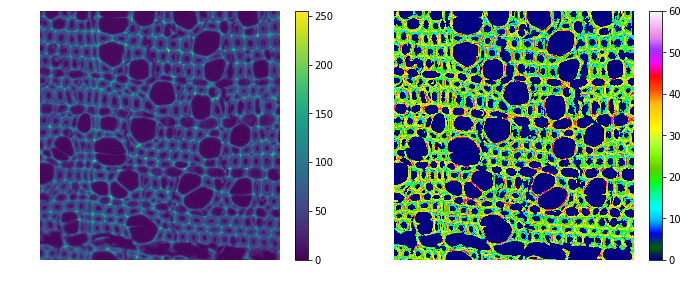

In [15]:
#result visualization
fig, ax=plt.subplots(1, 2, figsize=(10, 4))
im0=ax[0].imshow(FLM_list[9][1000:3000, 2000:5000], vmin=0, vmax=255)
fig.colorbar(im0, ax=ax[0])
ax[0].axis("off")

im1=ax[1].imshow(MFA_without_lumen_list_for_vis[9][1000: 3000, 2000:5000], vmin=0, vmax=60, cmap="gist_ncar")
fig.colorbar(im1, ax=ax[1])
ax[1].axis("off")
plt.tight_layout()
#plt.savefig(os.path.join(fig_save_path, "sample04_Trochodendron_FLM_MFA.png"), dpi=600)
plt.show()
plt.close()

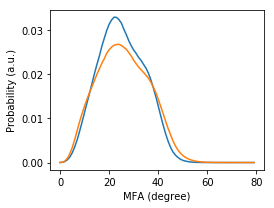

In [16]:
fig, ax=plt.subplots(1, 1, figsize=(4, 3))
ax.plot(MFA_hist_list[9]/np.sum(MFA_hist_list[0]))
ax.plot(MFA_hist_list[10]/np.sum(MFA_hist_list[1]))
ax.set_xlabel("MFA (degree)")
ax.set_ylabel("Probability (a.u.)")
#ax.set_yscale("log")
plt.tight_layout()
#plt.savefig(os.path.join(fig_save_path, "sample04_Trochodendron_MFA_hist.png"), dpi=300)
plt.show()
plt.close()

### Save as .png

In [17]:
MFA_map_path=os.path.join(fig_save_path, "MFA_map")
if os.path.exists(MFA_map_path)==False:
    os.makedirs(MFA_map_path)

for i in tqdm(range(len(MFA_without_lumen_list_for_vis))):
    plt.figure(figsize=(10, 6))
    plt.imshow(MFA_without_lumen_list_for_vis[i], vmin=0, vmax=60, cmap="gist_ncar")
    plt.colorbar()
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(MFA_map_path, str(sample_name_reference_list[i])+"MFA_map.png"), dpi=600)
    plt.close()


100%|██████████| 11/11 [00:50<00:00,  4.61s/it]


In [24]:
np.savez_compressed(os.path.join(current_path, "npz_file", "MFA_map_visualization.npz"), 
                    MFA_vis=MFA_without_lumen_list_for_vis, 
                    MFA_clac=MFA_without_lumen_list)

/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
